# Bigramme

## Analyse du dataset

In [103]:
words = open('prenoms.txt', 'r').read().splitlines()
print('Les 5 prénoms les plus populaires : ',words[:5])
print('Les 5 prénoms les moins populaires : ',words[-5:])
print('Le prénom le plus long : ',max(words, key=len))
print('Le prénom le plus court : ',min(words, key=len))


Les 5 prénoms les plus populaires :  ['MARIE', 'JEAN', 'PIERRE', 'MICHEL', 'ANDRÉ']
Les 5 prénoms les moins populaires :  ['ÉLOUEN', 'CHEYNA', 'BLONDIE', 'IMANN', 'GHILAIN']
Le prénom le plus long :  GUILLAUME-ALEXANDRE
Le prénom le plus court :  GUY


In [104]:
unique_characters = set()
for word in words:
  # Ajouter chaque caractère de la ligne à l'ensemble des caractères uniques
  for char in word.strip():
    unique_characters.add(char)
print('Nombre de caractères uniques : ',len(unique_characters))
print('Caractères uniques : ',unique_characters)

Nombre de caractères uniques :  45
Caractères uniques :  {'U', 'Ë', 'R', 'Ä', 'Ê', 'Y', 'Î', 'I', 'È', 'A', 'P', 'Û', 'Z', 'Ÿ', 'X', 'W', 'J', 'Æ', '-', 'O', 'Ü', 'K', 'F', "'", 'C', 'Q', 'À', 'G', 'T', 'Ô', 'H', 'S', 'Ç', 'Ï', 'V', 'Ö', 'M', 'N', 'L', 'B', 'D', 'Ù', 'É', 'Â', 'E'}


## Bigramme, qu'est ce que c'est ? 

Je rappelle que l'idée du projet est de prédire le prochain caractère à partir des caractères précédents. Dans le **bigramme**, on se base uniquement sur un seul caractère précédent pour prédire le caractère actuel. C'est la version la plus basique de ce type de modèle.

Bien entendu, on veut prédire un prénom à partir de rien et pour prédire la première lettre, on a besoin de savoir la probabilité que cette lettre soit la première. On va donc ajouter un caractère spécial '.' à au début et à la fin de chaque mot avant de construire nos bigrammes.

Dans chaque prénom, on a en fait plusieurs exemples de bigramme (chacun est indépendant).   
Si on considère le premier prénom, regardons le nombre de bigramme que l'on a : 

In [105]:
chs = ['.'] + list(words[0]) + ['.']
for ch1, ch2 in zip(chs, chs[1:]):
  bigram = (ch1, ch2)
  print(bigram)

('.', 'M')
('M', 'A')
('A', 'R')
('R', 'I')
('I', 'E')
('E', '.')


## Méthode par comptage

Rien que dans le premier prénom Marie, on a 6 bigrammes.   
Construisons maintenant un dictionnaire python qui regroupe tous les bigrammes du dataset en comptant leurs occurences. 

In [106]:
b = {}
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1
sorted(b.items(), key = lambda kv: -kv[1])
print('Les 5 bigrammes les plus fréquents : ',sorted(b.items(), key = lambda kv: -kv[1])[:5])

Les 5 bigrammes les plus fréquents :  [(('A', '.'), 7537), (('E', '.'), 6840), (('A', 'N'), 6292), (('N', '.'), 3741), (('N', 'E'), 3741)]


On a donc notre dictionnaire de fréquence des bigrammes dans l'intégralité de notre dataset. Comme on peut le voir, il est fréquent que des prénoms se terminent par A,E ou N et que les lettres A et N se suivent ainsi que les lettres N et E.

### Matrice d'occurence

Il est beaucoup plus simple de visualiser et de traiter les données sous forme matricielle. On va constuire une matrice de taille 46x46 (45 caractères comptés + le caractère spécial '.') avec la colonne correspondants à la ligne correspondant à la première lettre et la colonne correspondant à la seconde. 

In [107]:
import torch
N = torch.zeros((46, 46), dtype=torch.int32)

On va trier nos caractères et créer des table de recherche (look-up table) avec l'objet dictionnaire de python.  On veut pouvoir passer de caractère à entier (pour indexer dans la matrice) et inversement (pour reconstruire le prénoms à partir d'entiers).

In [108]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

On va maintenant remplir notre matrice : 

In [109]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

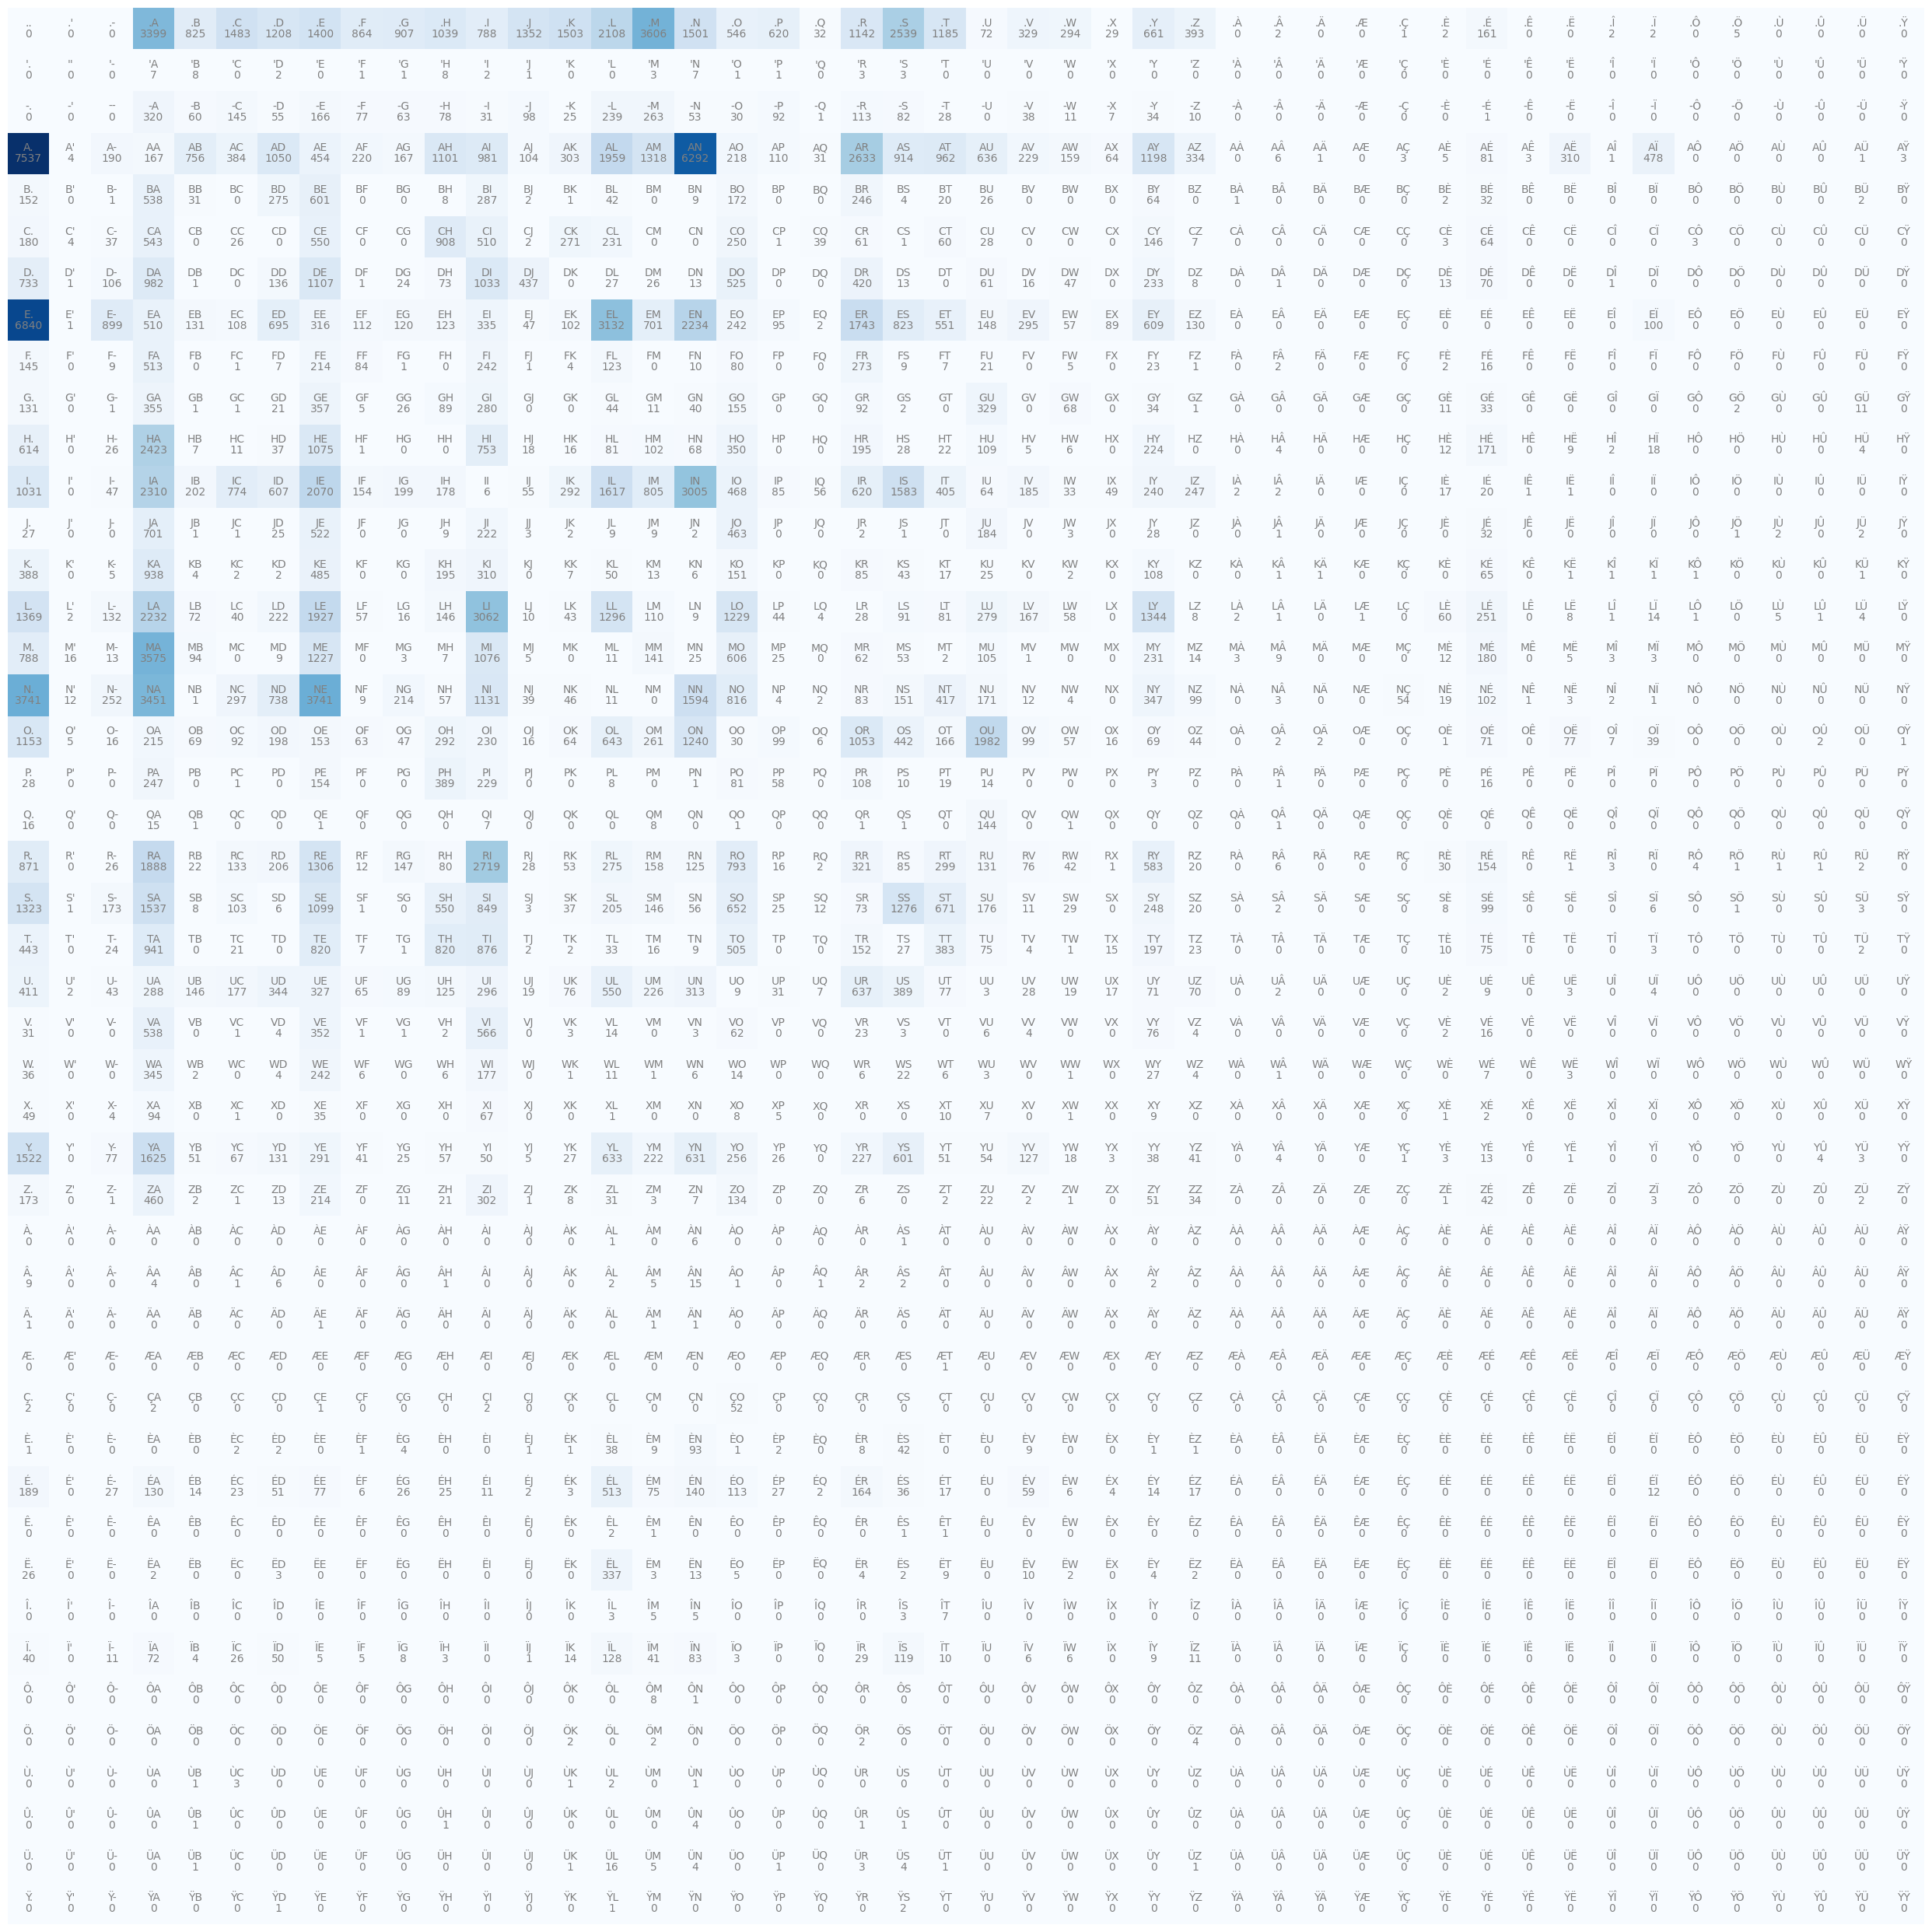

In [110]:
#Code pour dessiner une jolie matrice
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(32,32))
plt.imshow(N, cmap='Blues')
for i in range(46):
  for j in range(46):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

### Probabilités

Pour connaître la probabilité qu'un prénom commence par une certaine lettre, il faut regarder la ligne du caractère '.', c'est à dire la ligne 0 et normaliser chaque valeur par la somme des valeurs de cette ligne (pour obtenir des valeurs entre 0 et 1 qui ont une somme égale à 1).  

In [111]:
p = N[0].float()
p = p / p.sum()
print("Compte de la première ligne : ",N[0])
print("Probabilités : ",p)

Compte de la première ligne :  tensor([   0,    0,    0, 3399,  825, 1483, 1208, 1400,  864,  907, 1039,  788,
        1352, 1503, 2108, 3606, 1501,  546,  620,   32, 1142, 2539, 1185,   72,
         329,  294,   29,  661,  393,    0,    2,    0,    0,    1,    2,  161,
           0,    0,    2,    2,    0,    5,    0,    0,    0,    0],
       dtype=torch.int32)
Probabilités :  tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1330e-01, 2.7500e-02, 4.9433e-02,
        4.0267e-02, 4.6667e-02, 2.8800e-02, 3.0233e-02, 3.4633e-02, 2.6267e-02,
        4.5067e-02, 5.0100e-02, 7.0267e-02, 1.2020e-01, 5.0033e-02, 1.8200e-02,
        2.0667e-02, 1.0667e-03, 3.8067e-02, 8.4633e-02, 3.9500e-02, 2.4000e-03,
        1.0967e-02, 9.8000e-03, 9.6667e-04, 2.2033e-02, 1.3100e-02, 0.0000e+00,
        6.6667e-05, 0.0000e+00, 0.0000e+00, 3.3333e-05, 6.6667e-05, 5.3667e-03,
        0.0000e+00, 0.0000e+00, 6.6667e-05, 6.6667e-05, 0.0000e+00, 1.6667e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])


Pour générer des prénoms de manière aléatoires, on ne veut pas prendre la lettre avec le plus de probabilité d'être en premier (car on ne générerait que le même prénom à chaque fois). Ce qu'on voudrait c'est choisir une lettre en fonction de sa probabilité. Si la lettre n a une probabilité de 0.1, on voudrait la choisir 10% du temps.   
Pour faire cela à partir de notre vecteur de probabilité, on va utiliser la fonction torch.multinomial de pytorch.

In [112]:
ix = torch.multinomial(p, num_samples=1, replacement=True).item()
itos[ix]

'S'

A chaque fois qu'on l'appelle, on va obtenir une lettre différente en fonction de sa probabilité d'apparition dans notre dataset de test. 

Avec tous ces éléments, on est maintenant prêt à générer des prénoms à partir de notre matrice N. L'idéal pour éviter de renormalizer à chaque fois serait de créer une matrice avec directement les probabilités.   
C'est ce que l'on va faire.

In [113]:
# On copie N et on la convertit en float
P = N.float()
# On normalise chaque ligne
# On somme sur la première dimension (les colonnes)
print("Somme des lignes : ",P.sum(1, keepdims=True).shape)
P /= P.sum(1, keepdims=True) # /= est un raccourci pour P = P / P.sum(1, keepdims=True)
print("Matrice normalisée P est de taille : ",P.shape)
# On vérifie que la somme d'une ligne est égale à 1
print("Somme de la première ligne de P : ",P.sum(1)[0].item())

Somme des lignes :  torch.Size([46, 1])
Matrice normalisée P est de taille :  torch.Size([46, 46])
Somme de la première ligne de P :  1.0


**Point sur la division de matrice de taille différente** : Comme vous l'avez remarqué, on divise la matrice de taille (46,46) par une matrice de taille (46,1) ce qui semble être une opération impossible. Avec pytorch, il y a ce qu'on appelle des [broadcasting rules](https://pytorch.org/docs/stable/notes/broadcasting.html). Je vous invite très fortement à vous familiariser à ce qu'il y écrit sur ce lien, c'est une source d'erreur fréquente.  
En pratique, diviser la matrice de taille (46,46) par la matrice de taille (46,1) va "broadcaster" la matrice (46,1) en (46,46) en copiant 46 fois la matrice de base. Cela va permettre de réaliser l'opération comme on le souhaite. 

### Génération

Il est enfin temps de générer des prénoms avec notre méthode bigramme !!!    
Nous allons définir une fonction de génération de prénoms : 

In [114]:
def genName():
  out = []
  ix = 0 # On commence par '.'
  while True: # Tant qu'on n'a pas généré le caractère '.'
    p = P[ix] # On récupère la distribution de probabilité de la ligne correspondant au caractère actuel
    ix = torch.multinomial(p, num_samples=1, replacement=True).item() # On tire un échantillon
    out.append(itos[ix]) # On ajoute le caractère à notre prénom
    if ix == 0:
      break
  return ''.join(out)
genName()

'DENAVYSS.'

On peut par exemple générer 10 prénoms aléatoires :

In [115]:
for i in range(10):
  print(genName())

VE.
SYASANONERA.
D-E.
WANNENADDRI.
ORO.
GL.
MORIN.
K.
E.
DEL.


Comme vous pouvez le constater, la génération est assez catastrophique...   
Comment ça se fait ? C'est parce que le bigramme est une méthode catastrophique. Le fait de se baser uniquement sur le derniere caractère ne permet pas d'avoir une connaissance assez poussée pour permettre la génération de prénoms correctes.

## Evaluation du modèle

### Maximum de vraisemblance ou likelihood

On voudrait maintenant évaluer notre modèle sur l'ensemble d'entraînement. Pour ça on va utiliser le maximum de vraisemblance comme dans le second notebook du cours 1.   
Le maximum de vraisemblance ou likelihood est une mesure correspondant au produit des probabilités des évenements. Pour avoir un bon modèle, on cherche à maximiser le likelihood.   

In [116]:
productOfProbs = 1
for w in words[:2]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    productOfProbs *= prob
    print(f"La probabilité de {ch1}->{ch2} est {prob.item():.3f}")
print("Le produit des probabilités est : ",productOfProbs.item())

La probabilité de .->M est 0.120
La probabilité de M->A est 0.431
La probabilité de A->R est 0.084
La probabilité de R->I est 0.256
La probabilité de I->E est 0.119
La probabilité de E->. est 0.321
La probabilité de .->J est 0.045
La probabilité de J->E est 0.232
La probabilité de E->A est 0.024
La probabilité de A->N est 0.201
La probabilité de N->. est 0.212
Le produit des probabilités est :  4.520583629652464e-10


On voit rapidement que multiplier les probabilités va être un problème, ici on les multiplie sur 2 des 30 000 éléments du dataset et on obtient une valeur très faible. Si on les multiplie sur l'ensemble du dataset, ça sera une valeur non representable par un ordinateur.   

### log-likelihood

Pour résoudre ce problème de précision, on va utiliser le logarithme et ce pour plusieurs raisons:  
- La fonction log est monotone, c'est-à-dire que :  
Si $a>b$ alors $log(a)>log(b)$, le fait de maximiser le log likelihood est équivalent à maximiser le likelihood dans un contexte d'optimisation.
- Une propriété intéressante des logs (qui font que c'est fonction est très souvent utilisée en optimisation et en probabilité) est la règle suivante :  
$log(a \times b) = log(a) + log(b)$, cela nous permet d'éviter de multiplier des petites valeurs qui pourraient nous faire sortir de la précision d'un ordinateur.

On peut donc maximiser le log-likelihood plutôt que de maximiser le likelihood. Reprenons la boucle précédente et regardons ce que ça donne :  

In [117]:
sumOfLogs = 0
for w in words[:2]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    sumOfLogs += torch.log(prob)
print("La somme des log est : ",sumOfLogs.item())

La somme des log est :  -21.517210006713867


On obtient une valeur beaucoup plus raisonnable. Pour les problèmes d'optimisation, on aime souvent avoir une fonction à minimiser. Dans le cas d'un modèle parfait, chaque probabilité vaut 1 donc chaque log vaut 0 et la somme des logs va donc valoir 0 dans le meilleur cas. Sinon ça sera forcément des valeurs négatives car une probabilité est forcément inférieur à 1 et $log(a)<0 \text{ si } a<1$.  
Pour avoir un problème de minimisation, on va donc utiliser le negative log-likelihood qui correspond simplement à l'opposé du log-likelihood. 

Souvent, on va également prendre la moyenne plutôt que la somme car c'est plus lisible et équivalent en terme d'optimisation. Et nous allons le calculer sur l'ensemble des prénoms du dataset.

In [118]:
sumOfLogs = 0
n=0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    sumOfLogs += - torch.log(prob)
    n+=1
print("La somme des negative log est : ",sumOfLogs.item())
print("La moyenne des negative log est : ",sumOfLogs.item()/n)

La somme des negative log est :  564925.125
La moyenne des negative log est :  2.4960792002651053


Le negative log likelihood du dataset est donc de 2.9, vous pouvez également voir si votre prénom est commun ou peu commun par rapport à la moyenne du dataset.   
Pour cela, il suffit de remplacer mon prénom "SIMON" par votre prénom (en majuscule).

In [119]:
sumOfLogs = 0
n=0
for w in "SIMON":
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    sumOfLogs += - torch.log(prob)
    n+=1
print("La moyenne des negative log est : ",sumOfLogs.item()/n)

La moyenne des negative log est :  2.598056602478027


Si votre negative log likelihood est inférieur à celui du dataset, votre prénom est assez commun sinon il est plutôt peu commun.

## Approche par réseau de neurones

### Problème de l'approche "comptage"

Nous allons maintenant essayer de résoudre le même problème d'une manière différente. Nous avons résolu ce problème en comptant simplement les occurences des bigrammes et en calculant la probabilité par rapport à ça. C'est une méthode qui fonctionne pour des bigrammes mais qui ne fonctionnera pas pour des choses plus complexes comme des N-grammes. 

En effet, notre table de recherche est de taille 46x46 pour deux caractères, si on considère N caractères (donc N-1 caractères pour prédire le Nième), on a tout de suite beaucoup plus de possibilités. On peut calculer simplement que la table sera de taille $46^N$. Pour N=4 ça ferait une table de taille 4477456. Autant dire que pour des valeurs de contexte importantes (les modèles d'aujourd'hui ont un contexte de dizaines de milliers de tokens et il y a plus de 46 possibilités à chaque fois), c'est une approche qui ne fonctionnera pas du tout.

C'est pour cela que l'approche par réseau de neurones est très intéressante. Dans la suite de cours, nous allons montrer comment résoudre ce même problème à l'aide d'un réseau de neurones ce qui vous donnera une intuition sur les capacités du réseau lorsque le contexte augmente. 

### Dataset de notre réseau de neurones

Notre réseau de neurones va recevoir un caractère en entrée et va devoir prédire le caractère suivant. Comme fonction de loss, on pourra utiliser la fonction negative log likelihood pour essayer de se rapprocher de la valeur du bigramme par "comptage".

Commençons par créer notre dataset d'entraînement. On reprend la boucle de parcours des bigrammes de la partie précédente et cette fois on indexe deux listes xs pour les entrées et ys pour les labels. 

In [120]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. M
M A
A R
R I
I E
E .


In [121]:
print("valeurs d'entrée : ",xs)
print("valeurs de sortie : ",ys)

valeurs d'entrée :  tensor([ 0, 15,  3, 20, 11,  7])
valeurs de sortie :  tensor([15,  3, 20, 11,  7,  0])


Pour la valeur d'entrée 0 qui correspond à '.', on veut prédire un label 15 qui correspond à 'M'.

Le problème de ces listes, c'est que ce sont des entiers et il n'est pas possible de donner un entier en entrée d'un réseau de neurones. Dans le domaine du NLP, on utilise souvent le "one hot encoding" qui consiste à convertir un index en un vecteur de 0 avec un 1 à la position de l'index. La taille du vecteur correspond au nombre de classe possibles donc ici 46. 

In [122]:
import torch.nn.functional as F
# one-hot encoding
xenc = F.one_hot(xs, num_classes=46).float() # conversion en float pour le NN
print("Encodage one-hot des deux premiers caractères: ",xenc[:2])

Encodage one-hot des deux premiers caractères:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


Comme vous le voyez, on a un 1 à la position 0 du premier vecteur et un 1 à la position 15 du second. Ce sont ces vecteurs qui serviront d'entrée à notre réseau de neurones. On peut visualiser à quoi ressemble ces vecteurs pour avoir une intuition plus poussée de ce que le one hot encoding fait.

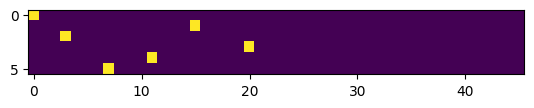

In [123]:
# Les 5 premiers vecteurs one-hot
plt.imshow(xenc)

### Notre réseau de neurones

Nous allons maintenant créer notre réseau de neurones. Il va s'agir d'un réseau de neurones extremement simple contenant une seule couche. Pour la taille de la couche, nous prenons en entrée un vecteur de taille $n \times 46$ il faudra donc une première dimension de taille 46 et en sortie on veut une distribution de probabilité sur l'ensemble des caractères. Notre couche de réseau sera donc de taille $46 \times 46$

Commençons par initialiser notre couche avec des valeurs aléatoires : 

In [124]:
# On met le paramètre requires_grad  True pour pouvoir optimiser la matrice par descente de gradient
W = torch.randn((46, 46), requires_grad=True) 

Le "forward" de notre réseau de neurones va simplement consister en une multiplication matricielle entre l'entrée et la couche. On va ensuite appliquer la fonction softmax (voir cours sur les CNN) pour obtenir une distribution de probabilités. 

In [125]:
# One hot encoding sur les entrées
xenc = F.one_hot(xs, num_classes=46).float() 
# Multiplication matricielle (forward pass)
logits = xenc @ W  # @ est la multiplication matricielle
#Softmax pour obtenir des probabilités
counts = logits.exp() 
probs = counts / counts.sum(1, keepdims=True) 
print(probs.shape)


torch.Size([6, 46])


On obtient une distribution de probabilités pour chacun de nos 6 caractères. On va visualiser les sorties de notre réseau de neurones non-entrainé et calculer le negative log likelihood pour voir où l'on se situe par rapport à notre modèle obtenu par "comptage".

In [126]:
nlls = torch.zeros(6)
for i in range(6):
  x = xs[i].item() # index de l'entrée
  y = ys[i].item() # index du label
  print('--------')
  print(f'bigramme actuel {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('entrée du réseau de neurones :', x)
  print('sortie du réseau (probabilité) :', probs[i])
  print('vrai label :', y)
  p = probs[i, y]
  print('probabilité donné par le réseau sur le caractère réel :', p.item())
  logp = torch.log(p)
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('negative log likelihood moyen, i.e. loss =', nlls.mean().item())

--------
bigramme actuel 1: .M (indexes 0,15)
entrée du réseau de neurones : 0
sortie du réseau (probabilité) : tensor([0.0031, 0.0077, 0.0067, 0.0040, 0.0266, 0.0044, 0.0516, 0.0138, 0.0118,
        0.0085, 0.0258, 0.0296, 0.0397, 0.0445, 0.0146, 0.0290, 0.0657, 0.0332,
        0.0063, 0.0268, 0.0158, 0.0174, 0.0130, 0.0112, 0.0112, 0.0257, 0.0061,
        0.0173, 0.0222, 0.0218, 0.0063, 0.0021, 0.0564, 0.0013, 0.0124, 0.0411,
        0.0195, 0.0526, 0.0084, 0.0567, 0.0024, 0.0410, 0.0542, 0.0199, 0.0097,
        0.0010], grad_fn=<SelectBackward0>)
vrai label : 15
probabilité donné par le réseau sur le caractère réel : 0.028988324105739594
negative log likelihood: 3.5408620834350586
--------
bigramme actuel 2: MA (indexes 15,3)
entrée du réseau de neurones : 15
sortie du réseau (probabilité) : tensor([0.0030, 0.0477, 0.0173, 0.0042, 0.0028, 0.0949, 0.0020, 0.0034, 0.0144,
        0.0109, 0.0267, 0.0132, 0.0045, 0.0100, 0.0117, 0.0160, 0.0526, 0.0024,
        0.0104, 0.0150, 0.0176, 0.

Pour le calcul du loss, on va calculer le negative log likelihood de la sortie de notre réseau par rapport au label de la manière suivante : 

In [127]:
# Calcul de la loss
loss = -probs[torch.arange(6), ys].log().mean()
print(loss.item())
# On remet les gradients à zéro (None est plus efficace)
W.grad = None 
# Calcul des gradients automatique de pytorch
loss.backward()
print(W.grad)

4.521402835845947
tensor([[0.0005, 0.0013, 0.0011,  ..., 0.0033, 0.0016, 0.0002],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


Comme vous le voyez, on a calculé les gradients de notre matrice W par rapport au loss. De la même manière que dans les cours précédents, on peut mettre à jour les poids du modèle dans le sens du gradient avec un pas (le learning_rate).

In [128]:
# avec un learning_rate de 0.1
W.data += -0.1 * W.grad

### Optimization

A partir de tout ce que nous venons de voir, nous pouvons maintenant rassembler les morceaux et optimiser notre modèle. 

**Création du dataset complet**   
On va commencer par créer notre dataset complet en reprenant la boucle précédente mais en parcourant l'ensemble des prénoms.

In [129]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)


number of examples:  226325


**Initialisation du modèle**    
On peut maintenant initialiser notre modèle comme précédement, fixer le learning_rate et le nombre d'itérations.

In [130]:
W = torch.randn((46, 46), requires_grad=True)
lr=50 # en pratique, dans ce petit problème, un learning rate de 50 fonctionne bien ce qui peut sembler étonnant
iterations=100

**Descente du gradient**    
Appliquons maintenant l'algorithme de descente du gradient sur 

In [131]:
# gradient descent
for k in range(iterations):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=46).float() # transformation one hot sur les entrées
  logits = xenc @ W
  probs=F.softmax(logits,dim=1) # On applique le softmax
  loss = -probs[torch.arange(num), ys].log().mean() # Calcul du negative log likelihood (loss)
  if k%10==0:
    print('loss iteration '+str(k)+' : ',loss.item())
  
  # retropropagation
  W.grad = None # Remettre la gradient à zéro à chaque itération (à ne pas oublier !!!!)
  loss.backward()
  
  # Mise à jour des poids
  W.data += -50 * W.grad

loss iteration 0 :  4.2137017250061035
loss iteration 10 :  2.922778844833374
loss iteration 20 :  2.749504327774048
loss iteration 30 :  2.6751708984375
loss iteration 40 :  2.633293867111206
loss iteration 50 :  2.606934070587158
loss iteration 60 :  2.5891902446746826
loss iteration 70 :  2.5765318870544434
loss iteration 80 :  2.567031145095825
loss iteration 90 :  2.559622287750244


Après 100 itérations, on obtient un negative log likelihood proche de celui du modèle par "comptage". C'est en fait la capacité maximum du modèle bigramme sur les données d'entraînement.   

**Generation de prénoms avec notre modèle**   
On peut maintenant générer des prénoms avec notre modèle.

In [132]:
for i in range(5):
  
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=46).float()
    logits = xenc @ W 
    # Prédiction des probabilités de la lettre suivante
    p=F.softmax(logits,dim=1)
    
    # On fait un tirage aléatoire de la prochaine lettre en suivante la distribution p 
    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    # Conversion en lettre
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

SSERILYNYEL.
LYADE.
DIA.
RORAHA.
SELYANEÏÙÂIENALY-MAMARELIGA.


### Notes supplémentaires

La matrice de poids $W$ est de la même taille que la matrice $N$ de la méthode par comptage. Ce qu'on vient de faire avec l'approche par réseau de neurones c'est en fait d'apprendre la matrice $N$.  
On peut confirmer l'intuition en regardant ce qu'il se passe lorsqu'on fait l'opération xenc @ W. Il s'agit d'une multiplication matricielle d'une matrice ligne de taille $1 \times 46$ par une matrice carré de taille $46 \times 46$, de plus la matrice ligne contient uniquement des zeros excepté un 1 à l'index $i$ à la lettre. Cette multiplication matricielle donne en résultat la ligne $i$ de la matrice $W$.   
Cela correspond exactement à ce qu'on faisait dans la méthode par comptage où l'on récuperait les probabilités de la ligne $i$ de $P$.